In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
import numpy as np

# Introduction to Langevin dynamic

### Part 1, set up the potential and plot it

### The potential is U(x) = 0.5 k (x - x0)^2 and F = -dU(x)/dx|

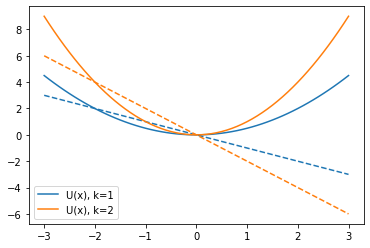

In [2]:
#this function returns the energy and force on a particle from a harmonic potential
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
        p = plt.plot(x_points,energies,label=label)
        plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
        plt.legend(loc=0)
        plt.savefig(str(function)+".png")
        
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

### Now you will implement the BAOAB scheme of Leimkuhler and Matthews (JCP, 2013)

The following equations are repeated (Do B,A,O,A,B then repeat) to move forward in time. The A and B steps represent increments by half a time step.

B: \nu(t)←\nu(t)+\frac{F(t)}{m}(dt/2)

A: x(t)←x(t)+v(t)(dt/2)

The differential equation for the O process is

dv(t)dt=−γvdt+2γkBT/m‾‾‾‾‾‾‾‾√dW

(dW
 is a random differential that samples a gaussian)

Solving this tells us the update rule:

O: v(t)←e−γdtv(t)+R(t)kBT/m‾‾‾‾‾‾√1−e−2γdt‾‾‾‾‾‾‾‾‾√

where R(t)
 is a gaussian random number with mean zero and standard-deviation 1.

In the following, I'm setting the mass m=1

In [3]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new


#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, **kwargs ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        #A
        x = position_update(x,v,dt)

        #O
        v = random_velocity_update(v,gamma,kBT,dt)
        
        #A
        x = position_update(x,v,dt)
        
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

## Part 3, run Langevin Dynamics simulation of a harmonic oscillator

1) Change my_k and see how it changes the frequency

2) Set my_k=1, and change my_gamma. Try lower values like 0.0001, 0.001, and higher values like 0.1, 1, 10. Do you see how underdamped, low γ
, looks more like standard harmonic oscillator, while overdamped, high γ
 looks more like a random walk?

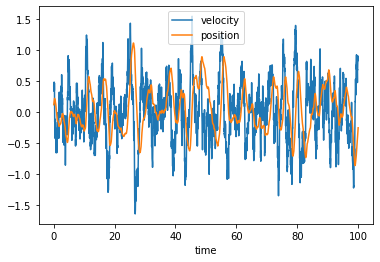

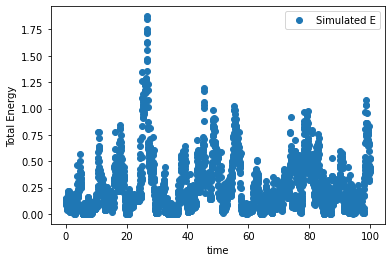

In [4]:
my_k = 2
my_max_time = 100
initial_position = .1
initial_velocity = .5

my_gamma=1
my_kBT=0.25
my_dt=0.01

times, positions, velocities, total_energies = baoab(harmonic_oscillator_energy_force, \
                                                                            my_max_time, my_dt, my_gamma, my_kBT, \
                                                                            initial_position, initial_velocity,\
                                                                            k=my_k)

plt.plot(times,velocities,marker='',label='velocity',linestyle='-')
plt.plot(times,positions,marker='',label='position',linestyle='-')

plt.xlabel('time')
plt.legend(loc='upper center')
plt.savefig("harm-v-x.png")
plt.figure()
plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()
plt.savefig("harm-e.png")

## Part 4, Histogram Position and Velocity
What is the probability of seeing a given position or velocity?

Now we are supposedly sampling the canonical distribution, so we should have:

P(x)=12πkBT/k√e−k(x−x0)22kBT
P
(
x
)
=
1
2
π
k
B
T
/
k
e
−
k
(
x
−
x
0
)
2
2
k
B
T

P(v)=12πkBT/m√e−mv22kBT
P
(
v
)
=
1
2
π
k
B
T
/
m
e
−
m
v
2
2
k
B
T

P(E)=e−E/kBT/∫e−E/kBTdE=1kBTe−E/kBT
P
(
E
)
=
e
−
E
/
k
B
T
/
∫
e
−
E
/
k
B
T
d
E
=
1
k
B
T
e
−
E
/
k
B
T

Set gamma to overdamped above and run the following cell

The histograms will be compared to the exact formulas.

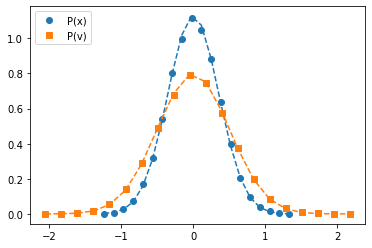

In [5]:
def bin_centers(bin_edges):
    return (bin_edges[1:]+bin_edges[:-1])/2.

def gaussian_x(x,k,kBT):
    denominator = np.sqrt(2*np.pi*kBT/k)
    numerator = np.exp(-k*(x**2)/(2*kBT))
    return numerator/denominator

def gaussian_v(v,kBT):
    denominator = np.sqrt(2*np.pi*kBT)
    numerator = np.exp(-(v**2)/(2*kBT))
    return numerator/denominator

#to get a good histogram, we need to run a lot longer than before
my_max_time = 25000

times, positions, velocities, total_energies = baoab(harmonic_oscillator_energy_force, 
                                                                            my_max_time, my_dt, my_gamma, my_kBT, \
                                                                            initial_position, initial_velocity,\
                                                                             k=my_k)

#let's only use data from the second half of the trajectory, so it can equilibrate
dist_hist, dist_bin_edges = np.histogram(positions[-len(positions)//2:],bins=20,density=True)
vel_hist, vel_bin_edges = np.histogram(velocities[-len(velocities)//2:],bins=20,density=True)
e_hist, e_bin_edges = np.histogram(total_energies[-len(total_energies)//2:],bins=20,density=True)


ideal_prediction_x = gaussian_x(x=bin_centers(dist_bin_edges),k=my_k,kBT=my_kBT )
p = plt.plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')
plt.plot(bin_centers(dist_bin_edges), ideal_prediction_x,linestyle='--',label='', color=p[0].get_color())

ideal_prediction_v = gaussian_v(v=bin_centers(vel_bin_edges),kBT=my_kBT )
p = plt.plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
plt.plot(bin_centers(vel_bin_edges), ideal_prediction_v,linestyle='--',label='', color=p[0].get_color())

plt.legend(loc='upper left')
plt.savefig("harm-hist-Px-Pv.png")
plt.figure()
p = plt.plot(bin_centers(e_bin_edges), e_hist,marker='s',label='P(E)',linestyle='')

#compute the energy histogram values to the boltzman factors for the observed energies
plt.plot(bin_centers(e_bin_edges), np.exp(-bin_centers(e_bin_edges)/my_kBT)/my_kBT,linestyle='--',color=p[0].get_color())
plt.yscale('log')
plt.xlabel("E")
plt.ylabel("P(E)")
plt.savefig("harm-hist-PE.png")

## Simulate a double well potential
Let's do a simulation in a double well also

U(x)=(k/4)((x−a)2)*((x+a)2)

This potential has a minimum at x=a
 and x=−a
. It also has a barrier at x=0
.

In [6]:
#this function returns the energy and force on a particle from a double well
def double_well_energy_force(x,k,a):
    #calculate the energy on force on the right hand side of the equal signs
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    return energy, force

plot_energy_force(double_well_energy_force, xmin=-4,xmax=+4, k=1, a=2)
plt.axhline(0,linestyle='--',color='black')
plt.axvline(0,linestyle='--',color='black')
plt.ylim(-10,10)
plt.savefig("dw-e-f.png")

## Part 5, run langevin verlet dynamics on the double well
We will see what happens when we change temperature my_KBT and barrier height my_a.

1) Run the simulation as is and see that the particle samples both the left and right sides of the well

2) Lower the temperature to 0.1, what happens?

3) Keep the temperature at 1.0, and raise a
 to 3, what happens?

when is the sampling ergodic?

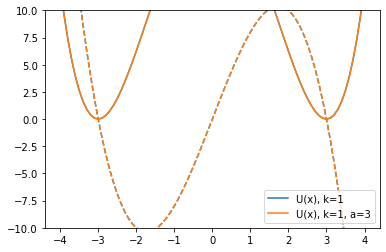

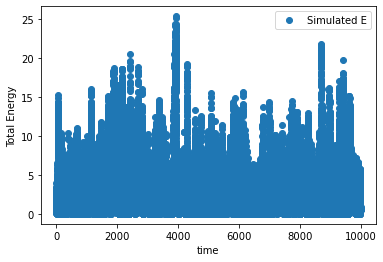

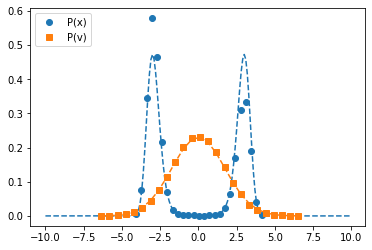

In [7]:
my_k = 1

#CHANGE THESE
my_kBT = 3.0
my_a = 3

plot_energy_force(double_well_energy_force, xmin=-4,xmax=+4, k=my_k, a=my_a)
plt.ylim(-10,10)
plt.figure()


my_initial_position = my_a
my_initial_velocity = 1

my_gamma = 0.1
my_dt = 0.05
my_max_time = 10000



times, positions, velocities, total_energies = baoab(double_well_energy_force, 
                                                                            my_max_time, my_dt, my_gamma, my_kBT,\
                                                                            my_initial_position, my_initial_velocity,\
                                                                             k=my_k, a=my_a)

plt.plot(times,positions,marker='o',label='position',linestyle='')
plt.plot(times,velocities,marker='s',label='velocity',linestyle='')

plt.xlabel('time')
plt.legend(loc='upper center')
plt.savefig("dw-x-v.png")
plt.figure()
initial_energy = total_energies[0]
plt.plot(times,total_energies,marker='o',linestyle='',label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()

plt.savefig("dw-E.png")
# histogramming the results
plt.figure()

dist_hist, dist_bin_edges = np.histogram(positions,bins=25,density=True)
vel_hist, vel_bin_edges = np.histogram(velocities,bins=25,density=True)

p = plt.plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')

#test against exact prediction
dd = 0.1
test_bin_positions = np.arange(-10,10,dd)
double_well_energies, double_well_froces = double_well_energy_force(test_bin_positions,my_k,my_a)

plt.plot(test_bin_positions, np.exp(-double_well_energies/my_kBT)/np.sum(dd*np.exp(-double_well_energies/my_kBT)),\
     linestyle='--',color=p[0].get_color())
p = plt.plot(bin_centers(vel_bin_edges), vel_hist,marker='s',label='P(v)',linestyle='')
ideal_prediction_v = gaussian_v(v=bin_centers(vel_bin_edges),kBT=my_kBT )
plt.plot(bin_centers(vel_bin_edges), ideal_prediction_v,linestyle='--',label='', color=p[0].get_color())


plt.legend(loc='upper left')
plt.savefig("dw-hist-px-pv.png")

## Next we try the double well afresh

### Part I, set up the double well potential

U(x) = (k/4)*((x-a)2)*((x+a)2)

The potential has two minimums, at x = +- a, and a local maxima at x = 0. The absolute maximas are at +- inf. 

In [1]:
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
## Create a function to return the potential energy and force
def function_double_well_energy_force(x,a=2,k=1):
    # x is a numpy array
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    return energy, force

### Part 2, plot the energy and the force

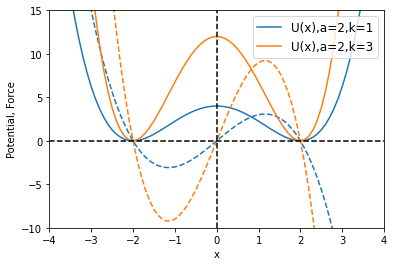

In [3]:
# This function will plot the energy and the force
def plot_energy_force(function,xmin=-4.0,xmax=4.0,spacing=0.1,a=2,k=1,):
    x_points = np.arange(xmin, xmax+spacing,spacing)
    energy,force = function(x_points,a,k)
    label = 'U(x)'
    label = label+','+'%s=%s,%s=%s'%("a",str(a),"k", str(k))
    p = ax.plot(x_points, energy, label=label)
    ax.plot(x_points, force, label='', color=p[0].get_color(), linestyle='--')
    ax.legend(loc=0)
    
    
fig, ax = plt.subplots() 
plt.rcParams["figure.figsize"] = (10,6)
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIG_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_energy_force(function_double_well_energy_force,k=1,a=2)
plot_energy_force(function_double_well_energy_force,k=3,a=2)
plt.axhline(0,linestyle='--',color='black')
plt.axvline(0,linestyle='--',color='black')
ax.set_ylim(-10, 15)
ax.set_xlim(-4, 4)
ax.set_xlabel("x")
ax.set_ylabel("Potential, Force")
plt.savefig("double_well_energy_force"+".png", dpi=300)

### Now we implement the straightforward Euler-Mauryama scheme. and the BAOAB method. We use the expression for the O process given to us, which is different from what I can derive (ask Johannes)

In [4]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new


#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency, a,k ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy, force = potential(x,a,k)
        v = velocity_update(v,force,dt)
        
        #A
        x = position_update(x,v,dt)

        #O
        v = random_velocity_update(v,gamma,kBT,dt)
        
        #A
        x = position_update(x,v,dt)
        
        # B
        potential_energy, force = potential(x,a,k)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

### Run Verlet langevin dynamics on the double well

In [15]:
my_k = 1

#CHANGE THESE
my_kBT = 10.0
my_a = 3.0

#plot_energy_force(function_double_well_energy_force, xmin=-4,xmax=+4, k=my_k, a=my_a)
#plt.ylim(-10,10)
#plt.figure()


my_initial_position = my_a
my_initial_velocity = 1
my_save_frequency = 3

my_gamma = 0.1
my_dt = 0.05
my_max_time = 10000

times, positions, velocities, total_energies = baoab(function_double_well_energy_force, 
                                                                            my_max_time, my_dt, my_gamma, my_kBT,\
                                                                            my_initial_position, my_initial_velocity,\
                                                                            my_save_frequency, k=my_k, a=my_a)

zip_positions = zip(times, positions)
list_times_positions = list(zip_positions)
f = open("position_double_well.dat", "w")

for line in list_times_positions:
    for value in line:
        f.write(str(value)+"    ")
    f.write ("\n")

# histogramming the results

def bin_centers(bin_edges):
    return (bin_edges[1:]+bin_edges[:-1])/2.
fig, ax = plt.subplots() 
plt.rcParams["figure.figsize"] = (10,6)
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIG_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

dist_hist, dist_bin_edges = np.histogram(positions,bins=50,density=True)
vel_hist, vel_bin_edges = np.histogram(velocities,bins=50,density=True)

ax.plot(bin_centers(dist_bin_edges), dist_hist,marker='o',label='P(x)',linestyle='')


In [16]:
# Calculate transition probability from one well to another.

#Define the full-widths from the dounle-well potentials by using the zeros of the second derivative of the potential
#The zeros are at -a/sqrt(3) and +a/sqrt(3)
#Make -a the midpoint of x and -a/sqrt(3) to get x, the leftmost point of the left full-width.
#Make a the midpoint of x and a/sqrt(3) to get x, the leftmost point of the left full-width.

fwhm_left = [-my_a*(2.0-1.0/np.sqrt(3.0)), -my_a/np.sqrt(3)]
fwhm_right = [my_a/np.sqrt(3), my_a*(2.0-1.0/np.sqrt(3.0))]

print (fwhm_left)
print (fwhm_right)
flag1 = 0
flag2 = 0
count1 = 0
count2 = 0
average1 = 0
average2 = 0
index = 0
somelist = []
for t in times:
    x = positions[index]
    if (x >= fwhm_left[0] and x <= fwhm_left[1]):
        flag1 = 1
        flag2 = 0
    elif (x >= fwhm_right[0] and x <= fwhm_right[1]):
        flag1 = 0
        flag2 = 1
    else:
        flag1 = 0
        flag2 = 0
        
    if (flag1 != 0):
        average1 = average1 + t
        count1 = count1 + 1
        if (count2 > 0):
            average2 = average2/count2
            somelist.append([2,average2])
            count2 = 0
            average2 = 0
    elif (flag2 != 0):
        average2 = average2 + t
        count2 = count2 + 1
        if count1 > 0:
            average1 = average1/count1
            somelist.append([1,average1])
            count1 = 0
            average1 = 0
    index = index + 1
        

# Now we have a list we can sort by average times (second item of the lists in the list)
sorted_list = sorted(somelist, key = lambda x: x[1])
print (somelist)
transtime = 0
counter = 0
av_trans_time = 0
for index in range(len(sorted_list)-1):
    item = sorted_list[index]
    nextitem = sorted_list[index+1]
    if (item[0] != nextitem[0]):
        transtime = transtime + (nextitem[1] - item[1])
        counter = counter + 1
    
if (counter > 0):
    av_trans_time = transtime/counter  
print ("average transfer time", av_trans_time)
print ("number of transfers", counter)

[-4.267949192431123, -1.7320508075688774]
[1.7320508075688774, 4.267949192431123]
[[2, 17.71558441558453], [1, 42.66176470588206], [2, 48.80999999999936], [1, 50.399999999999274], [2, 51.959999999999184], [1, 53.77499999999909], [2, 60.34354838709549], [1, 70.24166666666483], [2, 74.99999999999787], [1, 90.47661290322282], [2, 103.70999999999624], [1, 105.22499999999616], [2, 106.5899999999961], [1, 126.86481481481076], [2, 144.0899999999985], [1, 146.09999999999897], [2, 195.5159340659443], [1, 243.30000000002107], [2, 287.101396648076], [1, 330.39000000004086], [2, 331.87500000004115], [1, 334.41000000004175], [2, 335.77500000004204], [1, 337.4250000000425], [2, 338.7750000000427], [1, 340.05000000004304], [2, 343.34210526320174], [1, 409.6971584039281], [2, 482.58851351358896], [1, 490.9500000000773], [2, 492.90000000007785], [1, 577.209866392622], [2, 658.3499999999489], [1, 660.524999999947], [2, 662.549999999945], [1, 693.8454545453712], [2, 726.3714285713156], [1, 730.5599999998

In [6]:
my_k = 1

#CHANGE THESE
my_kBT = 10.0
my_a = 3.0

my_gamma = 0.1
my_dt = 0.05
my_max_time = 10000
my_kBT_array = np.linspace(0.1, 12, 10)
num_transition = []
for my_kBT in my_kBT_array:

    times, positions, velocities, total_energies = baoab(function_double_well_energy_force, 
                                                                                my_max_time, my_dt, my_gamma, my_kBT,\
                                                                                my_initial_position, my_initial_velocity,\
                                                                                my_save_frequency, k=my_k, a=my_a)


    # Calculate transition probability from one well to another.

    #Define the full-widths from the dounle-well potentials by using the zeros of the second derivative of the potential
    #The zeros are at -a/sqrt(3) and +a/sqrt(3)
    #Make -a the midpoint of x and -a/sqrt(3) to get x, the leftmost point of the left full-width.
    #Make a the midpoint of x and a/sqrt(3) to get x, the leftmost point of the left full-width.

    fwhm_left = [-my_a*(2.0-1.0/np.sqrt(3.0)), -my_a/np.sqrt(3)]
    fwhm_right = [my_a/np.sqrt(3), my_a*(2.0-1.0/np.sqrt(3.0))]

    print (fwhm_left)
    print (fwhm_right)
    flag1 = 0
    flag2 = 0
    count1 = 0
    count2 = 0
    average1 = 0
    average2 = 0
    index = 0
    somelist = []
    for t in times:
        x = positions[index]
        if (x >= fwhm_left[0] and x <= fwhm_left[1]):
            flag1 = 1
            flag2 = 0
        elif (x >= fwhm_right[0] and x <= fwhm_right[1]):
            flag1 = 0
            flag2 = 1
        else:
            flag1 = 0
            flag2 = 0

        if (flag1 != 0):
            average1 = average1 + t
            count1 = count1 + 1
            if (count2 > 0):
                average2 = average2/count2
                somelist.append([2,average2])
                count2 = 0
                average2 = 0
        elif (flag2 != 0):
            average2 = average2 + t
            count2 = count2 + 1
            if count1 > 0:
                average1 = average1/count1
                somelist.append([1,average1])
                count1 = 0
                average1 = 0
        index = index + 1


    # Now we have a list we can sort by average times (second item of the lists in the list)
    sorted_list = sorted(somelist, key = lambda x: x[1])
    transtime = 0
    counter = 0
    av_trans_time = 0
    for index in range(len(sorted_list)-1):
        item = sorted_list[index]
        nextitem = sorted_list[index+1]
        if (item[0] != nextitem[0]):
            transtime = transtime + (nextitem[1] - item[1])
            counter = counter + 1

    if (counter > 0):
        av_trans_time = transtime/counter  
    num_transition.append(counter)
    
ax.plot(my_kBT_array.tolist(), num_transition)

NameError: name 'my_initial_position' is not defined